# Navigating Turbulent Odor Plumes Using Reinforcement Learning

This notebook uses the Q-learning algorithm of Reinforcement Learning (RL) to train virtual agents to navigate a 2D turbulent odor plume. Turbulent odor plumes are spatiotemporally complex: odor signals arrive in random, unpredictable bursts, and odor concentration does follow continuous gradients, making plume navigation a difficult task. Suprisingly, there has been no published work on applying RL algorithms to turbulent odor plume navigation. 

## Q-learning algorithm
Q-learning updates a state-action value function, $Q(a, s)$, which quantifies the value of taking action $a$ when in state $s$. This function is updated in time using the Q-learning algorithm. At each timestep, the navigator takes an action $A$ to go from state $S$ to state $S'$, using whatever policy (greedy, $\epsilon$-greedy, etc.), where it receives a reward $R$. Then $Q(A, S)$ is updated using a *greedy* update rule (hence *off-policy*):

$\begin{align}
 Q(A, S) \leftarrow Q(A, S) + \alpha[R + \gamma \max_a Q(a, S')  - Q(A, S)]
\end{align}$

Here, $\alpha < 1$ and $\gamma < 1$ are update step-size and learning rate -- both hyperparameters in the simulation.

### State space: $\{s\}$

Following results found recently for navigation of odor plumes by fruit flies, we assume that navigators rely on the frequency of odor hits. An odor hit is the time at which the signal surpassses a given threshold. Running average of hit frequency, $W_freq$, is found by convolving the binary time series of odor hit times $w(t)$ with an exponential kernel ($\tau = 2$ seconds):

$W_{freq} = \int^t_{-\infty} e^{-(t-t')/\tau} w(t')dt'$

We discretize the state space into low and high frequency,

$S_1$: $W_{freq} < \text{thresh}$

$S_2$: $W_{freq} >= \text{thresh}$

where $thresh$ is to be chosen

### Action space: $\{a\}$
The navigators move on a grid, and we assume that there are 4 actions:

$A_1$: turn upwind (i.e. left)
$A_2$: walk straight
$A_3$: turn randomly in one of the 4 directions
$A_4$: turn toward the plume centerline

The last action $A_4$ means that, in the plume cone, flies in the top half will turn downward, and flies in the bottom half will turn upward. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append('src')
from utils import gen_plot
from models import *

### Define model subclasses

In [2]:
class centerline_upwind_downwind(odor_series_RL):
    """
    Reinforced learning simulation where navigators can i) go straight, 
    ii) go upwind, iii), turn toward plume centerline, or 
    iv) go downwind
    """

    def __init__(self):
        super().__init__()
    
    def def_actions(self):
        """
        Actions defined by motion `v' in run script
        """
        
        self._num_actions = 4
    
    def update_xys(self, xs, ys, vs, actions, iS):
        """
        Update navigator positions given selected actions
        """

        _xs = xs[iS]
        _ys = ys[iS]

        _xs[_xs > self.max_x] = self.max_x
        _ys[_ys > self.max_y] = self.max_y
        _xs[_xs < 0] = 0
        _ys[_ys < 0] = 0

        # Actions give change in velocity v: 0=right (downwind), 
        # 1=up (crosswind), 2=left (upwind), 3=down (crosswind). 
        
        # Actions: 
        #	0: go upwind (_v = 2)
        #	1: keep same direction (_v = v[iS])
        #	2: go toward centerline (_v = 1 or 3 depending on y)
        #	3: go downwind (_v = 0)
        
        _vs = np.empty(self.num_walkers)*np.nan
        _vs[actions == 0] = 2
        _vs[actions == 1] = vs[iS, actions == 1]
        _vs[actions == 2] = (ys[iS, actions == 2] > self.y_center)*3 + \
                            (ys[iS, actions == 2] <= self.y_center)*1
        _vs[actions == 3] = 0

        _xs[_vs == 0] += self.xy_step
        _ys[_vs == 1] += self.xy_step
        _xs[_vs == 2] -= self.xy_step
        _ys[_vs == 3] -= self.xy_step

        xs[iS + 1] = _xs
        ys[iS + 1] = _ys
        vs[iS + 1] = _vs

        return xs, ys, vs


class centerline_upwind_downwind_turns(odor_series_RL):
    """
    Reinforced learning simulation where navigators can i) go straight, 
    ii) turn upwind, iii) turn downwind, iv) possibly turn to centerline 
    """

    def __init__(self):
        super().__init__()
        
    def def_actions(self, centerline=True):
        """
        Actions defined by motion `v' in run script
        """
        
        if centerline == True:
            self._num_actions = 4
        else:
            self._num_actions = 3

    def update_xys(self, xs, ys, vs, actions, iS):
        """
        Update navigator positions given selected actions
        """

        _xs = xs[iS]
        _ys = ys[iS]

        _xs[_xs > self.max_x] = self.max_x
        _ys[_ys > self.max_y] = self.max_y
        _xs[_xs < 0] = 0
        _ys[_ys < 0] = 0

        # Actions give change in velocity v, 0-4; 0=right (downwind), 
        # 1=up (crosswind), 2=left (upwind), 3=down (crosswind). 
        # Actions: 
        #   0: go straight
        #   1: turn upwind (_v->2 if v = 1, 2, 3, _v->1,3 if v=0)
        #   2: turn downwind (_v->0 if v = 1, 0, 3, _v->1,3 if v=2)
        #   3: turn toward centerline 
        _vs = np.empty(self.num_walkers)*np.nan
        rnd = np.random.choice([1, 3])
        _vs[actions == 0] = vs[iS, actions == 0]
        _vs[actions == 1] = 2*(vs[iS, actions == 1] == 1) + \
                            2*(vs[iS, actions == 1] == 2) + \
                            2*(vs[iS, actions == 1] == 3) + \
                            rnd*(vs[iS, actions == 1] == 0)
        _vs[actions == 2] = 0*(vs[iS, actions == 2] == 1) + \
                            0*(vs[iS, actions == 2] == 3) + \
                            0*(vs[iS, actions == 2] == 0) + \
                            rnd*(vs[iS, actions == 2] == 2)
        _vs[actions == 3] = (ys[iS, actions == 3] > self.y_center)*3 + \
                            (ys[iS, actions == 3] <= self.y_center)*1
        
        _xs[_vs == 0] += self.xy_step
        _ys[_vs == 1] += self.xy_step
        _xs[_vs == 2] -= self.xy_step
        _ys[_vs == 3] -= self.xy_step

        xs[iS + 1] = _xs
        ys[iS + 1] = _ys
        vs[iS + 1] = _vs

        return xs, ys, vs

### centerline_upwind_downwind

In [3]:
a = centerline_upwind_downwind()
a.num_walkers = 500
a.def_actions()
a.num_steps = 2000
a.def_states(freq_bins=[-1, 0.5, 3, 5, 7, 100])
xs, ys, Q, Q_terminal, path_lengths = a.run()

99.9%

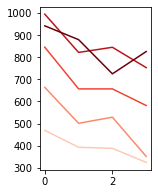

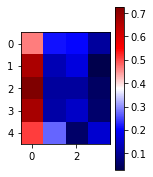

In [4]:
fig = plt.figure(figsize=(2, 3))
colors = plt.cm.Reds(np.linspace(0.2, 1.0, a._num_states))
for i in range(a._num_states):
    plt.plot(Q_terminal[i], color=colors[i])
plt.show()
temp = 100
fig = plt.figure(figsize=(2, 3))
Q_norm = (np.exp(Q_terminal.T/temp)/np.sum(np.exp(Q_terminal/temp), axis=-1)).T
plt.imshow(Q_norm, cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

In [ ]:
xs, ys, path_lengths = a.run_optimal_action(Q_terminal, temp=100)

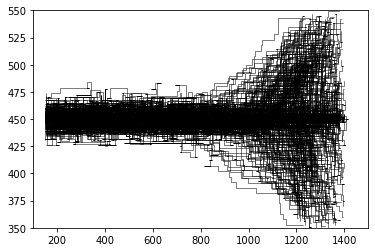

In [6]:
#colors = np.vstack((np.zeros(a.num_walkers), np.diff(xs, axis=0) < 0))
#plt.scatter(xs, ys, c = colors, s = 5, cmap=plt.cm.seismic)
for iW in range(a.num_walkers):
    plt.plot(xs[:path_lengths[iW], iW], ys[:path_lengths[iW], iW], color='k', lw=0.5)
plt.xlim(100, 1500)
plt.ylim(450 - 100, 450 + 100)
plt.show()

### centerline_upwind_downwind_turns

In [9]:
a = centerline_upwind_downwind_turns()
a.num_walkers = 100
a.def_actions()
a.num_steps = 2000
a.def_states(freq_bins=[-1, 0.5, 3, 5, 7, 100])
xs, ys, Q, Q_terminal, path_lengths = a.run()

99.9%

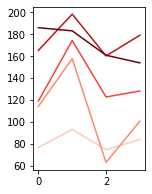

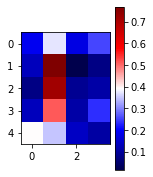

In [12]:
fig = plt.figure(figsize=(2, 3))
colors = plt.cm.Reds(np.linspace(0.2, 1.0, a._num_states))
for i in range(a._num_states):
    plt.plot(Q_terminal[i], color=colors[i])
plt.show()
temp = 25
fig = plt.figure(figsize=(2, 3))
Q_norm = (np.exp(Q_terminal.T/temp)/np.sum(np.exp(Q_terminal/temp), axis=-1)).T
plt.imshow(Q_norm, cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

In [ ]:
xs, ys, path_lengths = a.run_optimal_action(Q_terminal, temp=25)

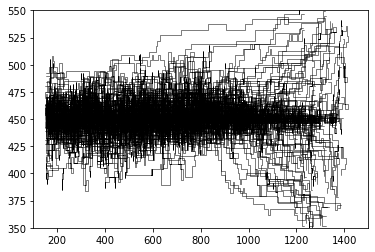

In [14]:
for iW in range(a.num_walkers):
    plt.plot(xs[:path_lengths[iW], iW], ys[:path_lengths[iW], iW], color='k', lw=0.5)
plt.xlim(100, 1500)
plt.ylim(450 - 100, 450 + 100)
plt.show()

### Finer motor control on turning

In [196]:
class upwind_turning(odor_series_RL):
    """
    Reinforced learning simulation where navigators can i) go straight, 
    ii) turn upwind, iii) turn downwind, iv) possibly turn to centerline 
    """

    def __init__(self):
        super().__init__()

    def def_actions(self):
        """
        Actions defined by motion `v' in run script
        """

        self._num_actions = 2

    def init_vars(self):
        """
        Initialize data structures used in simulation
        """

        xs = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        ys = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        vs = np.zeros((self.num_steps, self.num_walkers))
        states = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        Q = np.ones((self.num_steps, self._num_states, 
                     self._num_actions, self.num_walkers))

        # Binary vectory indicating if path reached source
        ends = np.zeros(self.num_walkers)

        # Length of trajectory from initial point to source in timesteps
        path_lengths = np.ones(self.num_walkers).astype(int)*self.num_steps

        # Initial x,y are random; initial motion is upwind (v = 2)
        xs[0] = np.random.randint(self.x0_min, 
                                  self.x0_max, 
                                  self.num_walkers)
        ys[0] = np.random.randint(self.y_center - self.y0_spread, 
                                  self.y_center + self.y0_spread, 
                                  self.num_walkers)
        vs[0] = np.ones(self.num_walkers)*2

        # Holds odor vector to define states
        odors = np.zeros((self.odor_vec_len, self.num_walkers))

        return xs, ys, vs, states, Q, ends, path_lengths, odors

    def update_xys(self, xs, ys, vs, actions, iS):
        """
        Update navigator positions given selected actions
        """

        _xs = xs[iS]
        _ys = ys[iS]

        _xs[_xs > self.max_x] = self.max_x
        _ys[_ys > self.max_y] = self.max_y
        _xs[_xs < 0] = 0
        _ys[_ys < 0] = 0

        turns = np.random.normal(np.pi/6, np.pi/18, self.num_walkers)
        turn_bin = np.random.choice([0.2, 1], size=self.num_walkers, p=[0.2, 0.8])
        turns *= turn_bin

        _vs = np.empty(self.num_walkers)*np.nan
        s1 = np.mod(vs[iS], 2*np.pi) < np.pi
        s2 = np.mod(vs[iS], 2*np.pi) >= np.pi

        # Top half and turn upwind
        _vs[s1*(actions == 0)] = vs[iS, s1*(actions == 0)] + turns[s1*(actions == 0)]

        # Bottom half and turn upwind
        _vs[s2*(actions == 0)] = vs[iS, s2*(actions == 0)] - turns[s2*(actions == 0)]

        # Top half and turn downwind
        _vs[s1*(actions == 1)] = vs[iS, s1*(actions == 1)] - turns[s1*(actions == 1)]

        # Bottom half and turn downwind
        _vs[s2*(actions == 1)] = vs[iS, s2*(actions == 1)] + turns[s2*(actions == 1)]

        _vs = np.mod(_vs, 2*np.pi)

        _xs = (np.cos(_vs)*self.xy_step).astype(int)
        _ys = (np.sin(_vs)*self.xy_step).astype(int)
        
        xs[iS + 1] = xs[iS] + _xs
        ys[iS + 1] = ys[iS] + _ys
        vs[iS + 1] = _vs

        return xs, ys, vs

In [210]:
a = upwind_turning()
a.x0_min = 1000
a.num_walkers = 200
a.def_actions()
a.num_steps = 2000
a.def_states(freq_bins=[-1, 0.01, 1, 2, 100])
xs, ys, Q, Q_terminal, path_lengths = a.run()

99.9%

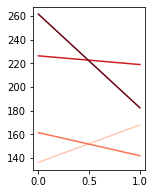

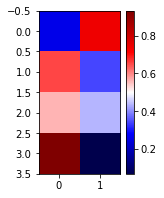

In [213]:
fig = plt.figure(figsize=(2, 3))
colors = plt.cm.Reds(np.linspace(0.2, 1.0, a._num_states))
for i in range(a._num_states):
    plt.plot(Q_terminal[i], color=colors[i])
plt.show()
temp = 30
fig = plt.figure(figsize=(2, 3))
Q_norm = (np.exp(Q_terminal.T/temp)/np.sum(np.exp(Q_terminal/temp), axis=-1)).T
plt.imshow(Q_norm, cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

In [208]:
xs, ys, path_lengths = a.run_optimal_action(Q_terminal, temp=15)

7.1%

KeyboardInterrupt: 

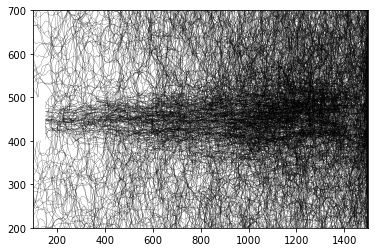

In [214]:
for iW in range(a.num_walkers):
    plt.plot(xs[:path_lengths[iW], iW], ys[:path_lengths[iW], iW], color='k', lw=0.2)
plt.xlim(100, 1500)
plt.ylim(450 - 250, 450 + 250)
plt.show()